In [1]:
import data
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import Dataset, DataLoader
import sys
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# Prepare training and evaluation data by using code from data.py file.
x_train, y_train = data.prepData(data.paths['train'])
x_val, y_val = data.prepData(data.paths['val'])

# Show image example
plt.imshow(cv2.cvtColor(x_train[0], cv2.COLOR_BGR2GRAY))
plt.show()

2it [00:37, 18.61s/it]
2it [00:00,  2.08it/s]


<Figure size 640x480 with 1 Axes>

In [2]:

# Class for dataset (creating batches).
class dataset(Dataset):
    def __init__(self):
        self.samples = len(x_train)
        self.x_data = x_train
        self.y_data = y_train

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return self.samples

# Convolutional Neural Network. Used for images.
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Use maxpool to reduce amount of pixels. Maxpool takes the max value of h*w pixels given and puts that one specific pixel into the new image.
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.2)
        # Set the first conv2d layer to a channel size of 3 (rgb) and the kernel size to 5 (5*5 is the amount of pixels it will process at a time)
        self.c1 = nn.Conv2d(3, 16, 5)
        self.c2 = nn.Conv2d(16, 32, 3)
        self.c3 = nn.Conv2d(32, 64, 3)
        self.c4 = nn.Conv2d(64, 128, 3)
        # Input size of the first linear layer. Calculated from image in last cnn layer. Channels*height*width.
        self.flattenedSize = 128*31*31
        self.fc1 = nn.Linear(self.flattenedSize, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.c1(x)))
        x = self.pool(F.relu(self.c2(x)))
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        #print(x.shape)
        # Flatten the image. Convert 2d to 1d to be used in linear layer.
        x = x.view(-1, self.flattenedSize)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.dropout2(F.relu(self.fc3(x)))
        x = self.fc4(x)

        return x
    
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    deviceType = "gpu"
else:
    device = torch.device("cpu")
    deviceType = "cpu"
    
print("Training on", deviceType)
    
net = Net().to(device)


Training on gpu


Training with 5 epochs


100%|██████████| 235/235 [00:17<00:00, 13.39it/s]


1 loss: 84.93009158223867
Model accuracy: 91 / 100 = 0.91


100%|██████████| 235/235 [00:17<00:00, 13.42it/s]


2 loss: 27.582810942083597
Model accuracy: 92 / 100 = 0.92


100%|██████████| 235/235 [00:17<00:00, 13.12it/s]


3 loss: 16.83756905887276
Model accuracy: 91 / 100 = 0.91


100%|██████████| 235/235 [00:17<00:00, 13.26it/s]


4 loss: 8.108736883848906
Model accuracy: 98 / 100 = 0.98


100%|██████████| 235/235 [00:17<00:00, 13.45it/s]


5 loss: 6.221674857661128
Model accuracy: 97 / 100 = 0.97


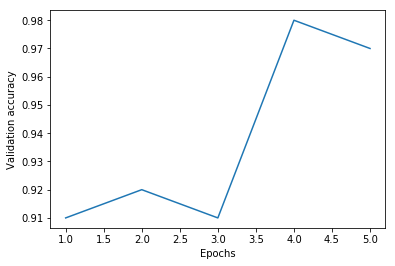

In [3]:
batch_size = 64
datas = dataset()
loader = DataLoader(dataset=datas, batch_size=batch_size, shuffle=True)
# Use cross entropy loss function (classification)
criterion = nn.CrossEntropyLoss()
# Use the ADAM optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
# Set number of epochs. This is the amount of times that the model will process the whole dataset.
epochs = 5
print("Training with", epochs, "epochs")
# List to graph the accuracy after each epoch.
epochsList = []
accuracyList = []
for epoch in range(epochs):
    totalLoss=0
    # Use tqdm to show a progress bar for each epoch.
    for (x_data, y_data) in tqdm(loader):
        x_data = x_data.to(device)
        y_data = y_data.to(device)
        x_data = x_data.view(-1, 3, 150, 150)
        output = net(x_data)
        loss = criterion(output, y_data)
        # Reset gradients from the previous update
        optimizer.zero_grad()
        # Backpropagate loss. Used to determine the change that's needed to the weights
        loss.backward()
        # Add loss to totalLoss
        totalLoss+=loss.item()
        # Make changes to weights
        optimizer.step()
    print(epoch+1, "loss:", totalLoss)
    correct = 0
    total = 0
    with torch.no_grad():
            net.eval()
            for i in range(len(x_val)):
                x = torch.from_numpy(x_val[i]).to(device)
                x = x.view(-1, 3, 150, 150)
                output = net(x)
                predict = torch.argmax(output, dim=1)
                if predict.item() == y_val[i]:
                    correct+=1
                total+=1
    print("Model accuracy:", correct, "/", total, "=", correct/total)
    epochsList.append(epoch+1)
    accuracyList.append(correct/total)
    
plt.plot(epochsList, accuracyList)
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.show()
    
